<a href="https://colab.research.google.com/github/joomj2000/DeepLearning/blob/main/transfer_learning_canndog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [2]:
import os
import time
import copy
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/skt_deep_learning/data/catanddog/train'

In [6]:
resnet18=models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터에 대한 변화를 계산할 필요가 없음을 나타냄 (모델 일부를 고정하고 학습하고자 할때 requires_grad=False로 사용)
set_parameter_requires_grad(resnet18)

In [8]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
resnet18.fc=nn.Linear(512,2)

In [10]:
for name,param in resnet18.named_parameters():
    if param.requires_grad:
        print(name,param.data)

fc.weight tensor([[ 0.0030, -0.0324, -0.0134,  ..., -0.0141,  0.0375,  0.0423],
        [ 0.0081, -0.0324, -0.0132,  ...,  0.0009,  0.0332, -0.0239]])
fc.bias tensor([ 0.0185, -0.0094])




---



In [17]:
data_path = '/content/drive/MyDrive/skt_deep_learning/data/catanddog/train'

transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


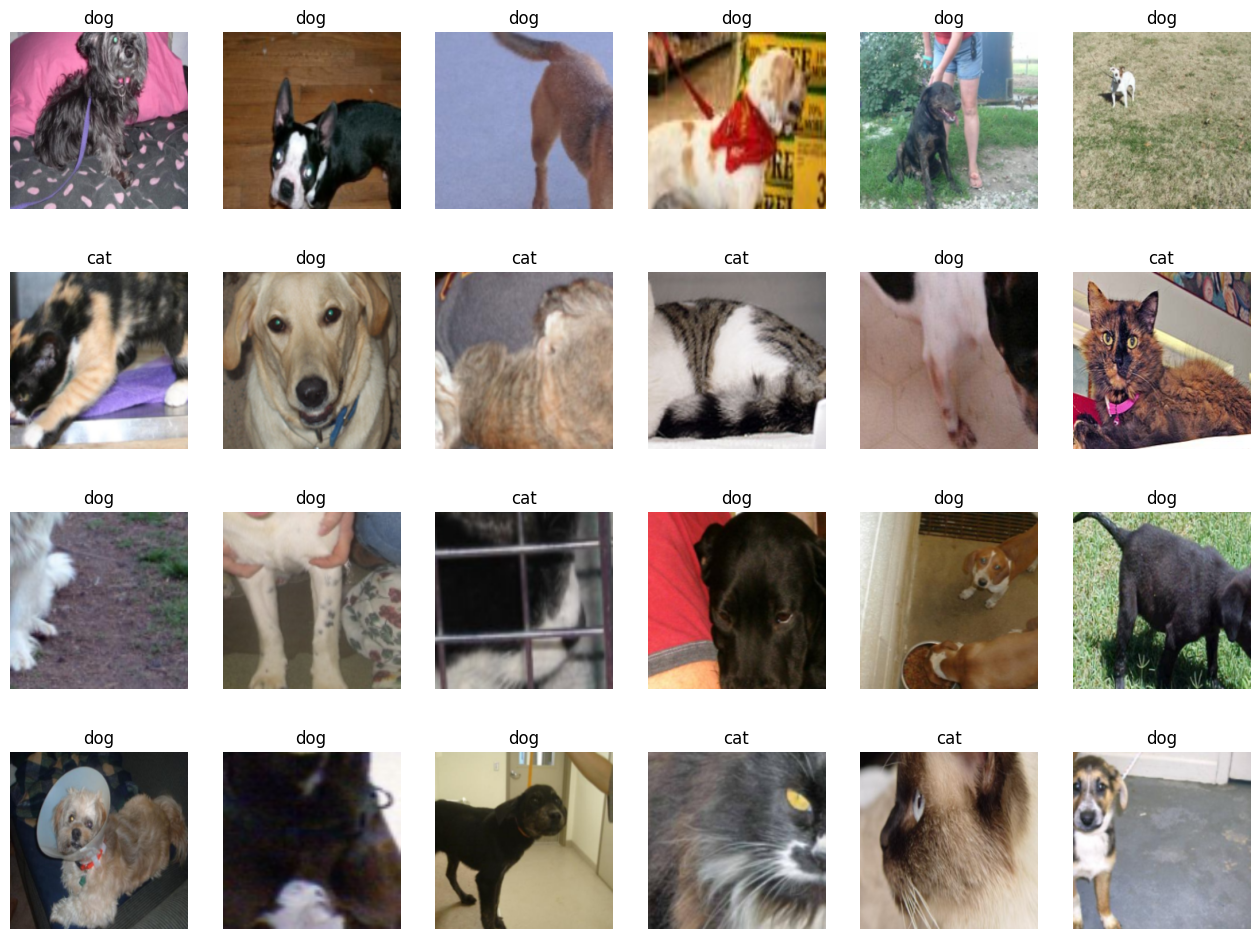

In [20]:
import matplotlib.pyplot as plt
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [21]:
model=models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad=False

model.fc=nn.Linear(512,2)

for param in model.fc.parameters(): #fc가 가지고 있는 파라미터 전달
    param.requires_grad=True

optimizer=torch.optim.Adam(model.fc.parameters()) #fc만 학습할거니까 넣음 (하지만 requries_grad를 꺼놨기 때문에 다 적어도 됨.)
cost=torch.nn.CrossEntropyLoss() #손실함수 정의
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/skt_deep_learning/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [25]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion=torch.nn.CrossEntropyLoss()
train_acc,train_loss=train_model(model,train_loader,criterion,optimizer,device)

Epoch 0/12
----------
Loss: 0.6298 Acc: 0.6234

Epoch 1/12
----------
Loss: 0.4349 Acc: 0.7766

Epoch 2/12
----------
Loss: 0.3727 Acc: 0.8260

Epoch 3/12
----------
Loss: 0.2821 Acc: 0.8727

Epoch 4/12
----------
Loss: 0.2692 Acc: 0.8857

Epoch 5/12
----------
Loss: 0.2460 Acc: 0.8961

Epoch 6/12
----------
Loss: 0.2310 Acc: 0.9247

Epoch 7/12
----------
Loss: 0.1938 Acc: 0.9221

Epoch 8/12
----------
Loss: 0.2167 Acc: 0.9221

Epoch 9/12
----------
Loss: 0.2078 Acc: 0.9325

Epoch 10/12
----------
Loss: 0.1904 Acc: 0.9325

Epoch 11/12
----------
Loss: 0.2648 Acc: 0.8701

Epoch 12/12
----------
Loss: 0.1619 Acc: 0.9481

Training complete in 0m 15s
Best Acc: 0.948052


In [26]:
test_path = '/content/drive/MyDrive/skt_deep_learning/data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224), #test의 랜덤성을 없애기 위해 random을 사용하지 않음
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [29]:
import glob
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/skt_deep_learning/data/catanddog/' + '*.pth') #확장자가 pth인 모든 파일을 불러옴
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval() # drop과 같은 랜덤한 요소를 끄기 (랜섬덤 끄기 )
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            #preds[preds >= 0.5] = 1 #없어도 되는 코드 (앞에 값을 주면 그래야함)
            #preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [31]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['/content/drive/MyDrive/skt_deep_learning/data/catanddog/00.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/01.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/02.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/03.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/04.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/05.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/06.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/07.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/08.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/09.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/10.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/11.pth', '/content/drive/MyDrive/skt_deep_learning/data/catanddog/12.pth']
Loading model /content/drive/MyDrive/skt_deep_learning/data/catanddog/00.pth
Acc: 0.8367

Loading model /content/drive/MyDrive/sk